# Introducción

El objetivo de este trabajo es entrenar una red neuronal convolucional, a partir de un banco de imágenes en un sistema de carpetas jerárquicas, para que identifique números decimales utilizando una cámara de laptop. Se apoyó en el uso de IA generativa a lo largo de este escrito; los momentos en los cuales se utilizó (en mayor o menor medida) están indicados con comentarios en las celdas correspondientes.

La idea era entrenar 5 redes neuronales distintas, pero eventualmente se entrenaron más, y se escogió una con la cual hacer las predicciones en tiempo real. Considerar ver el video que demuestra su funcionamiento.

# Lectura de archivos

Las imágenes que se usarán para el dataset se encuentran en dos carpetas de drive. Primero necesito poder "leerlas", antes de procesarlas para que tengan todas el mismo formato.

Montamos a drive para tener acceso a las imágenes

In [1]:
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt
import numpy as np
import os

from tensorflow.keras.preprocessing.image import ImageDataGenerator

from tensorflow.keras.models import Sequential
from tensorflow.keras import layers
from tensorflow.keras.layers import Dense, Flatten, Dropout
from tensorflow.keras.optimizers import Adam

from tensorflow.keras.callbacks import EarlyStopping

In [2]:
cwd = os.getcwd()
train_dir = rf"{cwd}\Numbers\Numbers\Train"  # Raw string para evitar problemas con '\'
test_dir = rf"{cwd}\Numbers\Numbers\Test"

# Generación de datasets 

In [3]:
### INFO PARA IR CAMBIANDO PARA LUEGO IR MEJORANDO EL ENTRENAMIENTO
sn = 140

targetSize = (sn, sn)
inputShape = (sn, sn, 1)

In [4]:
### colab con Gemini AI


train_datagen = ImageDataGenerator(rescale=1./255, dtype='float32', validation_split=0.3) #el dtype para que sean en byn
test_datagen = ImageDataGenerator(rescale=1./255, dtype='float32')

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=targetSize,
    batch_size=32,
    class_mode='categorical',
    color_mode='grayscale',
    subset='training', # Indica que este es el conjunto de entrenamiento
)

validation_generator = train_datagen.flow_from_directory(
    train_dir, # Usa el mismo directorio para validación
    target_size=targetSize,
    batch_size=32,
    class_mode='categorical',
    color_mode='grayscale',
    subset='validation', # Indica que este es el conjunto de validación
)

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=targetSize,
    batch_size=32,
    class_mode='categorical',
    color_mode='grayscale'
)

Found 3911 images belonging to 10 classes.
Found 1670 images belonging to 10 classes.
Found 1615 images belonging to 10 classes.


# Visualización de imágenes importadas

Y efectivamente, deberían ser alrededor de 7200 imágenes en total. Vamos por buen camino. Veamos 5 imágenes al azar de nuestro set de entrenamiento, y ver que todo esté en orden

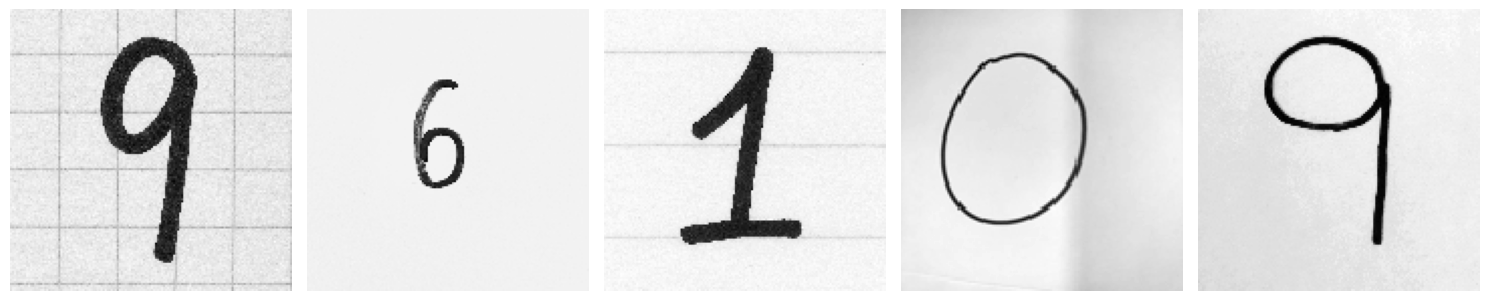

In [ ]:
### GEMINI AI

# Assuming you have already created your train_generator as shown before

# Get the total number of batches in the training set
total_batches = len(train_generator)

# Select 5 random batch indices
random_batch_indices = np.random.choice(total_batches, size=5, replace=False)

# Create a figure and axes for the plot
fig, axes = plt.subplots(1, 5, figsize=(15, 6))  # 1 rows, 5 columns
axes = axes.flatten()  # Flatten the axes array for easier iteration

# Iterate through the random batches and display images
for i, batch_index in enumerate(random_batch_indices):
    # Get a batch of images and labels
    batch_images, batch_labels = train_generator[batch_index]

    # Select a random image from the batch
    image_index = np.random.randint(0, batch_images.shape[0])
    image = batch_images[image_index]

    # Display the image on the corresponding subplot
    axes[i].imshow(image.squeeze(), cmap='gray')  # squeeze() removes the channel dimension if it's 1
    axes[i].axis('off')  # Turn off axis ticks and labels

plt.tight_layout()
plt.show()

**El punto es que se agarraron bien los números**

# Entrenamiento de primer modelo

Ahora es momento de entrenar una red neuronal convolucional. Para determinar el modelo a utilizar para hacer predicciones en tiempo real, entrenaré 5 modelos, uno buscando ser mejor que el anterior.

Empecemos con el primero. Lo que lo distinguirá será:
- activaciones relu
- una sola capa de convolución
- kernels 3*3

In [ ]:
m1 = Sequential() #modelo 1

# convolucion
m1.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=inputShape))
m1.add(layers.MaxPooling2D((2, 2)))

# capas densas y dropout
m1.add(Flatten())
m1.add(Dense(64, activation='relu'))
m1.add(Dense(32, activation='relu'))
m1.add(Dense(16, activation='relu'))
m1.add(Dropout(0.2))
m1.add(Dense(10, activation='softmax'))

# compilacion
m1.compile(
    optimizer=Adam(learning_rate=0.001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

m1.summary()

c:\Users\joabl\anaconda3\envs\tf\lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_1 (Conv2D)               │ (None, 138, 138, 32)   │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 69, 69, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 152352)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 64)             │     9,750,592 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 16)             │           528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 16)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 10)             │           170 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 9,753,690 (37.21 MB)

 Trainable params: 9,753,690 (37.21 MB)

 Non-trainable params: 0 (0.00 B)

Estos son los componentes de la arquitectura de la red neuronal convolucional compilada y su rol en el manejo de imagenes:
- Capa convolucional: Realiza convoluciones utilizando distintos filtros, de determinado tamaño, con las imagenes de entrada. En este caso, dado que no se aplica padding, teniendo kernels 3x3 causa que se pierdan 2 pixeles por dimension. Devuelve mapas de características, no imagenes tal cual
- Max pooling: Explora el mapa de características de entrada, lo divide en secciones (cada una de un tamaño determinado), y devuelve un segundo mapa de características más pequeño, para extraer las más importantes
- Flatten: Convierte los mapas de características en vectores, tipo de dato necesario para las capas densas
- Capas densas: Utilizan vectores de entrada para las funciones de activación de cada neurona. Cada una devuelve un vector para la siguiente capa
- Dropout: Omite un porcentaje de neuronas por cada batch procesado durante el entrenamiento (segun Copilot), y se usa para mitigar overfitting. 
- Capa densa de salida: Lo mismo que las anteriores capas densas, pero su función de activación es característica del problema en cuestión. En este caso, tiene solo 10 neuronas, y cada una arroja la probabilidad de que la imagen de entrada pertenezca a alguna clase en particular. 

In [10]:
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True) # a bajarle la patience porque cada vez mas se pondra más feo el asunto

In [22]:
h1 = m1.fit(# history 1
    train_generator,
    epochs=30,
    batch_size=64,
    validation_data=validation_generator,
    callbacks=[early_stopping]
)

Epoch 1/30
123/123 ━━━━━━━━━━━━━━━━━━━━ 42s 332ms/step - accuracy: 0.1234 - loss: 2.5130 - val_accuracy: 0.3000 - val_loss: 2.0076
Epoch 2/30
123/123 ━━━━━━━━━━━━━━━━━━━━ 41s 334ms/step - accuracy: 0.3135 - loss: 1.9145 - val_accuracy: 0.4952 - val_loss: 1.6337
Epoch 3/30
123/123 ━━━━━━━━━━━━━━━━━━━━ 42s 339ms/step - accuracy: 0.4445 - loss: 1.5496 - val_accuracy: 0.5365 - val_loss: 1.4588
Epoch 4/30
123/123 ━━━━━━━━━━━━━━━━━━━━ 42s 338ms/step - accuracy: 0.5603 - loss: 1.2759 - val_accuracy: 0.5922 - val_loss: 1.3670
Epoch 5/30
123/123 ━━━━━━━━━━━━━━━━━━━━ 42s 342ms/step - accuracy: 0.6507 - loss: 0.9865 - val_accuracy: 0.6210 - val_loss: 1.2996
Epoch 6/30
123/123 ━━━━━━━━━━━━━━━━━━━━ 41s 338ms/step - accuracy: 0.7269 - loss: 0.8055 - val_accuracy: 0.6503 - val_loss: 1.2551
Epoch 7/30
123/123 ━━━━━━━━━━━━━━━━━━━━ 42s 339ms/step - accuracy: 0.7724 - loss: 0.6864 - val_accuracy: 0.6407 - val_loss: 1.3334
Epoch 8/30
123/123 ━━━━━━━━━━━━━━━━━━━━ 42s 340ms/step - accuracy: 0.8266 - loss: 0

este entrenamiento se planeaba hacer durante 30 épocas. para cada una, iba a agrupar 64 elementos de los datos de entrenamiento, e iba a usarlos para el proceso de descenso de gradiente, y luego pasar a los siguientes 64 elementos, hasta recorrer todos los datos de entrenamiento, y luego pasar a la siguiente época. En particular, si la accuracy no mejoraba significativamente en 5 épocas, entonces el entrenamiento se iba a detener e iba a agarrar los weights que correspondieran al "mejor momento" del modelo.

En este caso no corrió las 30 épocas, sino que corrió 11. Es decir, en la época 6 empezó a ver que no mejoraba, le tuve paciencia otras 5, y luego ya dejó de entrenarse porque no vio mejores resultados en accuracy

In [23]:
m1.save('m1.h5')

# Entrenamiento de 5 modelos adicionales

Quiero ser métodico, y saber específicamente qué cambios provocan mejorías en el modelo. Por ello, en esta ocasión agregaré otra capa de convolución, para ver si mejora la extracción de características

segun copilot conviene ampliar el numero de filtros en orden ascendiente al usar varias capas de convolucion, porque se abstraen primero cosas mas abstractas, luego caracteristicas mas complejas, pero parece no ser tan necesario variar el tamaño de los kernels. si lo es, lo haré después

## 1er modelo adicional

In [7]:
m2 = Sequential() #modelo 2

# convolucion
m2.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=inputShape))
m2.add(layers.Conv2D(64, (3, 3), activation='relu'))
m2.add(layers.MaxPooling2D((2, 2)))

# capas densas y dropout
m2.add(Flatten())
m2.add(Dense(64, activation='relu'))
m2.add(Dense(32, activation='relu'))
m2.add(Dense(16, activation='relu'))
m2.add(Dropout(0.2))
m2.add(Dense(10, activation='softmax'))

# compilacion
m2.compile(
    optimizer=Adam(learning_rate=0.001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

m2.summary()

c:\Users\joabl\anaconda3\envs\tf\lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 138, 138, 32)   │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 136, 136, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 68, 68, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 295936)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │    18,939,968 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 16)             │           528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 16)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 10)             │           170 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 18,961,562 (72.33 MB)

 Trainable params: 18,961,562 (72.33 MB)

 Non-trainable params: 0 (0.00 B)

In [8]:
h2 = m2.fit(# history 2
    train_generator,
    epochs=30,
    batch_size=64,
    validation_data=validation_generator,
    callbacks=[early_stopping]
)

c:\Users\joabl\anaconda3\envs\tf\lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/30
123/123 ━━━━━━━━━━━━━━━━━━━━ 192s 2s/step - accuracy: 0.1511 - loss: 2.8709 - val_accuracy: 0.4647 - val_loss: 1.6549
Epoch 2/30
123/123 ━━━━━━━━━━━━━━━━━━━━ 135s 1s/step - accuracy: 0.5048 - loss: 1.4805 - val_accuracy: 0.6862 - val_loss: 1.1874
Epoch 3/30
123/123 ━━━━━━━━━━━━━━━━━━━━ 70s 560ms/step - accuracy: 0.6969 - loss: 0.9159 - val_accuracy: 0.6910 - val_loss: 1.1452
Epoch 4/30
123/123 ━━━━━━━━━━━━━━━━━━━━ 69s 562ms/step - accuracy: 0.8121 - loss: 0.5955 - val_accuracy: 0.7168 - val_loss: 1.1947
Epoch 5/30
123/123 ━━━━━━━━━━━━━━━━━━━━ 69s 561ms/step - accuracy: 0.8632 - loss: 0.4250 - val_accuracy: 0.7228 - val_loss: 1.2266
Epoch 6/30
123/123 ━━━━━━━━━━━━━━━━━━━━ 67s 541ms/step - accuracy: 0.8955 - loss: 0.3182 - val_accuracy: 0.7407 - val_loss: 1.5409
Epoch 7/30
123/123 ━━━━━━━━━━━━━━━━━━━━ 74s 601ms/step - accuracy: 0.9292 - loss: 0.2435 - val_accuracy: 0.7455 - val_loss: 1.5577
Epoch 8/30
123/123 ━━━━━━━━━━━━━━━━━━━━ 70s 573ms/step - accuracy: 0.9467 - loss: 0.176

## 2do modelo adicional

Debido a que aumentó la accuracy, ahora incrementaré las neuronas en las capas densas

In [8]:
m3 = Sequential() #modelo 2

# convolucion
m3.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=inputShape))
m3.add(layers.Conv2D(64, (3, 3), activation='relu'))
m3.add(layers.MaxPooling2D((2, 2)))

# capas densas y dropout
m3.add(Flatten())
m3.add(Dense(128, activation='relu'))
m3.add(Dense(64, activation='relu'))
m3.add(Dense(32, activation='relu'))
m3.add(Dropout(0.2))
m3.add(Dense(10, activation='softmax'))

# compilacion
m3.compile(
    optimizer=Adam(learning_rate=0.001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

m3.summary()

c:\Users\joabl\anaconda3\envs\tf\lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 138, 138, 32)   │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 136, 136, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 68, 68, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 295936)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │    37,879,936 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 10)             │           330 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 37,909,418 (144.61 MB)

 Trainable params: 37,909,418 (144.61 MB)

 Non-trainable params: 0 (0.00 B)

Aquí aumentaré el batch size debido al aumento de parámetros por calcular

In [11]:
h3 = m3.fit(# history 3
    train_generator,
    epochs=30,
    batch_size=128,
    validation_data=validation_generator,
    callbacks=[early_stopping]
)

c:\Users\joabl\anaconda3\envs\tf\lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/30
123/123 ━━━━━━━━━━━━━━━━━━━━ 118s 953ms/step - accuracy: 0.1575 - loss: 2.7735 - val_accuracy: 0.5461 - val_loss: 1.5425
Epoch 2/30
123/123 ━━━━━━━━━━━━━━━━━━━━ 79s 640ms/step - accuracy: 0.5942 - loss: 1.2997 - val_accuracy: 0.7186 - val_loss: 1.0392
Epoch 3/30
123/123 ━━━━━━━━━━━━━━━━━━━━ 76s 616ms/step - accuracy: 0.8248 - loss: 0.5957 - val_accuracy: 0.7377 - val_loss: 0.9876
Epoch 4/30
123/123 ━━━━━━━━━━━━━━━━━━━━ 75s 605ms/step - accuracy: 0.9092 - loss: 0.3035 - val_accuracy: 0.7383 - val_loss: 1.1175
Epoch 5/30
123/123 ━━━━━━━━━━━━━━━━━━━━ 75s 609ms/step - accuracy: 0.9497 - loss: 0.2175 - val_accuracy: 0.7605 - val_loss: 1.2935
Epoch 6/30
123/123 ━━━━━━━━━━━━━━━━━━━━ 75s 612ms/step - accuracy: 0.9588 - loss: 0.1525 - val_accuracy: 0.7629 - val_loss: 1.4433
Epoch 7/30
123/123 ━━━━━━━━━━━━━━━━━━━━ 74s 603ms/step - accuracy: 0.9811 - loss: 0.0807 - val_accuracy: 0.7665 - val_loss: 1.6998
Epoch 8/30
123/123 ━━━━━━━━━━━━━━━━━━━━ 74s 601ms/step - accuracy: 0.9782 - loss: 

## 3er modeloa dicional

Hubo mejoria, entonces ahora agregaré una capa de convolución

In [13]:
m4 = Sequential() #modelo 2

# convolucion
m4.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=inputShape))
m4.add(layers.Conv2D(64, (3, 3), activation='relu'))
m4.add(layers.Conv2D(128, (3, 3), activation='relu'))
m4.add(layers.MaxPooling2D((2, 2)))

# capas densas y dropout
m4.add(Flatten())
m4.add(Dense(128, activation='relu'))
m4.add(Dense(64, activation='relu'))
m4.add(Dense(32, activation='relu'))
m4.add(Dropout(0.2))
m4.add(Dense(10, activation='softmax'))

# compilacion
m4.compile(
    optimizer=Adam(learning_rate=0.001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

m4.summary()

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_4 (Conv2D)               │ (None, 138, 138, 32)   │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 136, 136, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ (None, 134, 134, 128)  │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 67, 67, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_2 (Flatten)             │ (None, 574592)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 128)            │    73,547,904 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_11 (Dense)                │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_12 (Dense)                │ (None, 10)             │           330 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 73,651,242 (280.96 MB)

 Trainable params: 73,651,242 (280.96 MB)

 Non-trainable params: 0 (0.00 B)

De nuevo, por el aumento de parámetros aumentaré tmb el batch size

In [14]:
h4 = m4.fit(# history 4
    train_generator,
    epochs=30,
    batch_size=256,
    validation_data=validation_generator,
    callbacks=[early_stopping]
)

Epoch 1/30
123/123 ━━━━━━━━━━━━━━━━━━━━ 217s 2s/step - accuracy: 0.1732 - loss: 2.8910 - val_accuracy: 0.5635 - val_loss: 1.4918
Epoch 2/30
123/123 ━━━━━━━━━━━━━━━━━━━━ 208s 2s/step - accuracy: 0.6159 - loss: 1.2070 - val_accuracy: 0.6988 - val_loss: 1.0527
Epoch 3/30
123/123 ━━━━━━━━━━━━━━━━━━━━ 208s 2s/step - accuracy: 0.8158 - loss: 0.5866 - val_accuracy: 0.7551 - val_loss: 0.9692
Epoch 4/30
123/123 ━━━━━━━━━━━━━━━━━━━━ 214s 2s/step - accuracy: 0.9031 - loss: 0.3154 - val_accuracy: 0.7605 - val_loss: 1.2543
Epoch 5/30
123/123 ━━━━━━━━━━━━━━━━━━━━ 214s 2s/step - accuracy: 0.9517 - loss: 0.1774 - val_accuracy: 0.7713 - val_loss: 1.4076
Epoch 6/30
123/123 ━━━━━━━━━━━━━━━━━━━━ 213s 2s/step - accuracy: 0.9658 - loss: 0.1366 - val_accuracy: 0.7832 - val_loss: 1.5012
Epoch 7/30
123/123 ━━━━━━━━━━━━━━━━━━━━ 206s 2s/step - accuracy: 0.9724 - loss: 0.0885 - val_accuracy: 0.7754 - val_loss: 1.7344
Epoch 8/30
123/123 ━━━━━━━━━━━━━━━━━━━━ 205s 2s/step - accuracy: 0.9743 - loss: 0.0942 - val_accu

## 4to modelo adicional

No me convenció agregarle esa capa de convolución. Buscaré usar un maxpooling de 4x4 mejor. Tmb modificaré el learning rate para compensar

In [15]:
m5 = Sequential() #modelo 2

# convolucion
m5.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=inputShape))
m5.add(layers.Conv2D(64, (3, 3), activation='relu'))
m5.add(layers.MaxPooling2D((4, 4)))

# capas densas y dropout
m5.add(Flatten())
m5.add(Dense(128, activation='relu'))
m5.add(Dense(64, activation='relu'))
m5.add(Dense(32, activation='relu'))
m5.add(Dropout(0.2))
m5.add(Dense(10, activation='softmax'))

# compilacion
m5.compile(
    optimizer=Adam(learning_rate=0.0005),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

m5.summary()

c:\Users\joabl\anaconda3\envs\tf\lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_7 (Conv2D)               │ (None, 138, 138, 32)   │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_8 (Conv2D)               │ (None, 136, 136, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 34, 34, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_3 (Flatten)             │ (None, 73984)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_13 (Dense)                │ (None, 128)            │     9,470,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_14 (Dense)                │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_15 (Dense)                │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_16 (Dense)                │ (None, 10)             │           330 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 9,499,562 (36.24 MB)

 Trainable params: 9,499,562 (36.24 MB)

 Non-trainable params: 0 (0.00 B)

Reduciré el batch size para compensar el menor numero de params

In [16]:
h5 = m5.fit(# history 4
    train_generator,
    epochs=30,
    batch_size=32,
    validation_data=validation_generator,
    callbacks=[early_stopping]
)

Epoch 1/30
123/123 ━━━━━━━━━━━━━━━━━━━━ 58s 466ms/step - accuracy: 0.1815 - loss: 2.2323 - val_accuracy: 0.5192 - val_loss: 1.5408
Epoch 2/30
123/123 ━━━━━━━━━━━━━━━━━━━━ 58s 467ms/step - accuracy: 0.5478 - loss: 1.3980 - val_accuracy: 0.6796 - val_loss: 1.1178
Epoch 3/30
123/123 ━━━━━━━━━━━━━━━━━━━━ 57s 460ms/step - accuracy: 0.7090 - loss: 0.9244 - val_accuracy: 0.7323 - val_loss: 0.9869
Epoch 4/30
123/123 ━━━━━━━━━━━━━━━━━━━━ 58s 467ms/step - accuracy: 0.8248 - loss: 0.5850 - val_accuracy: 0.7659 - val_loss: 0.8711
Epoch 5/30
123/123 ━━━━━━━━━━━━━━━━━━━━ 57s 466ms/step - accuracy: 0.8768 - loss: 0.4127 - val_accuracy: 0.7635 - val_loss: 0.9931
Epoch 6/30
123/123 ━━━━━━━━━━━━━━━━━━━━ 57s 462ms/step - accuracy: 0.9194 - loss: 0.2722 - val_accuracy: 0.7952 - val_loss: 0.9795
Epoch 7/30
123/123 ━━━━━━━━━━━━━━━━━━━━ 57s 465ms/step - accuracy: 0.9425 - loss: 0.2180 - val_accuracy: 0.7838 - val_loss: 1.0839
Epoch 8/30
123/123 ━━━━━━━━━━━━━━━━━━━━ 57s 465ms/step - accuracy: 0.9523 - loss: 0

## 5to modelo adicional

okey mejoró un poco más el modelo (de 0.76 en cv a 0.79). Probaré agregando dos capas densas, y cambiando la activación de la primera capa densa oculta 

In [17]:
m6 = Sequential() #modelo 2

# convolucion
m6.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=inputShape))
m6.add(layers.Conv2D(64, (3, 3), activation='relu'))
m6.add(layers.MaxPooling2D((4, 4)))

# capas densas y dropout
m6.add(Flatten())
m6.add(Dense(128, activation='elu'))
m6.add(Dense(112, activation='relu'))
m6.add(Dense(64, activation='relu'))
m6.add(Dense(48, activation='relu'))
m6.add(Dense(32, activation='relu'))
m6.add(Dropout(0.2))
m6.add(Dense(10, activation='softmax'))

# compilacion
m6.compile(
    optimizer=Adam(learning_rate=0.0005),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

m6.summary()

c:\Users\joabl\anaconda3\envs\tf\lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_9 (Conv2D)               │ (None, 138, 138, 32)   │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_10 (Conv2D)              │ (None, 136, 136, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 34, 34, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_4 (Flatten)             │ (None, 73984)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_17 (Dense)                │ (None, 128)            │     9,470,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_18 (Dense)                │ (None, 112)            │        14,448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_19 (Dense)                │ (None, 64)             │         7,232 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_20 (Dense)                │ (None, 48)             │         3,120 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_21 (Dense)                │ (None, 32)             │         1,568 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_22 (Dense)                │ (None, 10)             │           330 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 9,515,594 (36.30 MB)

 Trainable params: 9,515,594 (36.30 MB)

 Non-trainable params: 0 (0.00 B)

In [18]:
h6 = m6.fit(# history 6
    train_generator,
    epochs=30,
    batch_size=32,
    validation_data=validation_generator,
    callbacks=[early_stopping]
)

Epoch 1/30
123/123 ━━━━━━━━━━━━━━━━━━━━ 58s 464ms/step - accuracy: 0.1557 - loss: 2.2861 - val_accuracy: 0.5228 - val_loss: 1.5644
Epoch 2/30
123/123 ━━━━━━━━━━━━━━━━━━━━ 57s 465ms/step - accuracy: 0.5392 - loss: 1.3842 - val_accuracy: 0.6814 - val_loss: 1.0841
Epoch 3/30
123/123 ━━━━━━━━━━━━━━━━━━━━ 57s 461ms/step - accuracy: 0.7538 - loss: 0.7758 - val_accuracy: 0.7251 - val_loss: 0.9523
Epoch 4/30
123/123 ━━━━━━━━━━━━━━━━━━━━ 57s 464ms/step - accuracy: 0.8580 - loss: 0.4811 - val_accuracy: 0.7659 - val_loss: 1.0587
Epoch 5/30
123/123 ━━━━━━━━━━━━━━━━━━━━ 58s 468ms/step - accuracy: 0.9094 - loss: 0.3301 - val_accuracy: 0.7653 - val_loss: 1.0747
Epoch 6/30
123/123 ━━━━━━━━━━━━━━━━━━━━ 60s 487ms/step - accuracy: 0.9359 - loss: 0.2170 - val_accuracy: 0.7653 - val_loss: 1.2772
Epoch 7/30
123/123 ━━━━━━━━━━━━━━━━━━━━ 58s 466ms/step - accuracy: 0.9547 - loss: 0.1491 - val_accuracy: 0.7988 - val_loss: 1.1998
Epoch 8/30
123/123 ━━━━━━━━━━━━━━━━━━━━ 57s 463ms/step - accuracy: 0.9730 - loss: 0

## 6to modelo adicional?

tengo la teoria de que hay un bottleneck en el tamaño de los datos. convertiré las imagenes a 280 y veré qué pasa al entrenar esto con la misma arquitectura del 4to modelo adicional

In [19]:
### INFO PARA IR CAMBIANDO PARA LUEGO IR MEJORANDO EL ENTRENAMIENTO
sn = 280

targetSize = (sn, sn)
inputShape = (sn, sn, 1)

In [20]:
### colab con Gemini AI


train_datagen = ImageDataGenerator(rescale=1./255, dtype='float32', validation_split=0.3) #el dtype para que sean en byn
test_datagen = ImageDataGenerator(rescale=1./255, dtype='float32')

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=targetSize,
    batch_size=32,
    class_mode='categorical',
    color_mode='grayscale',
    subset='training', # Indica que este es el conjunto de entrenamiento
)

validation_generator = train_datagen.flow_from_directory(
    train_dir, # Usa el mismo directorio para validación
    target_size=targetSize,
    batch_size=32,
    class_mode='categorical',
    color_mode='grayscale',
    subset='validation', # Indica que este es el conjunto de validación
)

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=targetSize,
    batch_size=32,
    class_mode='categorical',
    color_mode='grayscale'
)

Found 3911 images belonging to 10 classes.
Found 1670 images belonging to 10 classes.
Found 1615 images belonging to 10 classes.


In [ ]:
m7 = Sequential() #modelo 2

# convolucion
m7.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=inputShape))
m7.add(layers.Conv2D(64, (3, 3), activation='relu'))
m7.add(layers.MaxPooling2D((4, 4)))

# capas densas y dropout
m7.add(Flatten())
m7.add(Dense(128, activation='relu'))
m7.add(Dense(64, activation='relu'))
m7.add(Dense(32, activation='relu'))
m7.add(Dropout(0.2))
m7.add(Dense(10, activation='softmax'))

# compilacion
m7.compile(
    optimizer=Adam(learning_rate=0.0005),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

m7.summary()

c:\Users\joabl\anaconda3\envs\tf\lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_11 (Conv2D)              │ (None, 278, 278, 32)   │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_12 (Conv2D)              │ (None, 276, 276, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 69, 69, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_5 (Flatten)             │ (None, 304704)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_23 (Dense)                │ (None, 128)            │    39,002,240 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_24 (Dense)                │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_25 (Dense)                │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_26 (Dense)                │ (None, 10)             │           330 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 39,031,722 (148.89 MB)

 Trainable params: 39,031,722 (148.89 MB)

 Non-trainable params: 0 (0.00 B)

cambiaré el batch size. si esto no mejora, me quedaré con el mejor modelo hasta la fecha

In [23]:
h7 = m7.fit(# history 6
    train_generator,
    epochs=30,
    batch_size=64,
    validation_data=validation_generator,
    callbacks=[early_stopping]
)

Epoch 1/30
123/123 ━━━━━━━━━━━━━━━━━━━━ 182s 1s/step - accuracy: 0.8400 - loss: 0.5515 - val_accuracy: 0.7251 - val_loss: 1.0851
Epoch 2/30
123/123 ━━━━━━━━━━━━━━━━━━━━ 197s 2s/step - accuracy: 0.9181 - loss: 0.3051 - val_accuracy: 0.7323 - val_loss: 1.2472
Epoch 3/30
123/123 ━━━━━━━━━━━━━━━━━━━━ 197s 2s/step - accuracy: 0.9480 - loss: 0.1870 - val_accuracy: 0.7395 - val_loss: 1.3642
Epoch 4/30
123/123 ━━━━━━━━━━━━━━━━━━━━ 198s 2s/step - accuracy: 0.9647 - loss: 0.1220 - val_accuracy: 0.7293 - val_loss: 1.4942
Epoch 5/30
123/123 ━━━━━━━━━━━━━━━━━━━━ 197s 2s/step - accuracy: 0.9740 - loss: 0.0927 - val_accuracy: 0.7359 - val_loss: 1.8132
Epoch 6/30
123/123 ━━━━━━━━━━━━━━━━━━━━ 196s 2s/step - accuracy: 0.9797 - loss: 0.0908 - val_accuracy: 0.7275 - val_loss: 1.8060


decidi entrenar otro porque habia corrido otras 5 epocas antes de las que se muestran, pero luego me tuve que mover de lugar, y no sé si en algún punto el algoritmo se cicló, así que entrenaré de nuevo. cambiare el maxpool a (2,2). tmb haré que la patience=3

In [24]:
m8 = Sequential() #modelo 2

# convolucion
m8.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=inputShape))
m8.add(layers.Conv2D(64, (3, 3), activation='relu'))
m8.add(layers.MaxPooling2D((2, 2)))

# capas densas y dropout
m8.add(Flatten())
m8.add(Dense(128, activation='relu'))
m8.add(Dense(64, activation='relu'))
m8.add(Dense(32, activation='relu'))
m8.add(Dropout(0.2))
m8.add(Dense(10, activation='softmax'))

# compilacion
m8.compile(
    optimizer=Adam(learning_rate=0.0005),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

m8.summary()

c:\Users\joabl\anaconda3\envs\tf\lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_13 (Conv2D)              │ (None, 278, 278, 32)   │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_14 (Conv2D)              │ (None, 276, 276, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_6 (MaxPooling2D)  │ (None, 138, 138, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_6 (Flatten)             │ (None, 1218816)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_27 (Dense)                │ (None, 128)            │   156,008,576 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_28 (Dense)                │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_29 (Dense)                │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_30 (Dense)                │ (None, 10)             │           330 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 156,038,058 (595.24 MB)

 Trainable params: 156,038,058 (595.24 MB)

 Non-trainable params: 0 (0.00 B)

In [25]:
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True) # a bajarle la patience porque cada vez mas se pondra más feo el asunto
h8 = m8.fit(# history 8
    train_generator,
    epochs=30,
    batch_size=128,
    validation_data=validation_generator,
    callbacks=[early_stopping]
)

Epoch 1/30
123/123 ━━━━━━━━━━━━━━━━━━━━ 295s 2s/step - accuracy: 0.1545 - loss: 2.8263 - val_accuracy: 0.4719 - val_loss: 1.7105
Epoch 2/30
123/123 ━━━━━━━━━━━━━━━━━━━━ 293s 2s/step - accuracy: 0.5152 - loss: 1.5451 - val_accuracy: 0.6018 - val_loss: 1.3303
Epoch 3/30
123/123 ━━━━━━━━━━━━━━━━━━━━ 291s 2s/step - accuracy: 0.7220 - loss: 0.9180 - val_accuracy: 0.6784 - val_loss: 1.1837
Epoch 4/30
123/123 ━━━━━━━━━━━━━━━━━━━━ 290s 2s/step - accuracy: 0.8247 - loss: 0.5943 - val_accuracy: 0.6814 - val_loss: 1.2489
Epoch 5/30
123/123 ━━━━━━━━━━━━━━━━━━━━ 291s 2s/step - accuracy: 0.8992 - loss: 0.3329 - val_accuracy: 0.7054 - val_loss: 1.2953
Epoch 6/30
123/123 ━━━━━━━━━━━━━━━━━━━━ 292s 2s/step - accuracy: 0.9312 - loss: 0.2579 - val_accuracy: 0.6868 - val_loss: 1.4118


# Mejor performance de los modelos

El que mejor funcionó fue `m6`, entonces apreciamos como va aumentando la accuracy (y por tanto, disminuyendo el costo) durante su entrenamiento y validación cruzada a lo largo de las épocas.

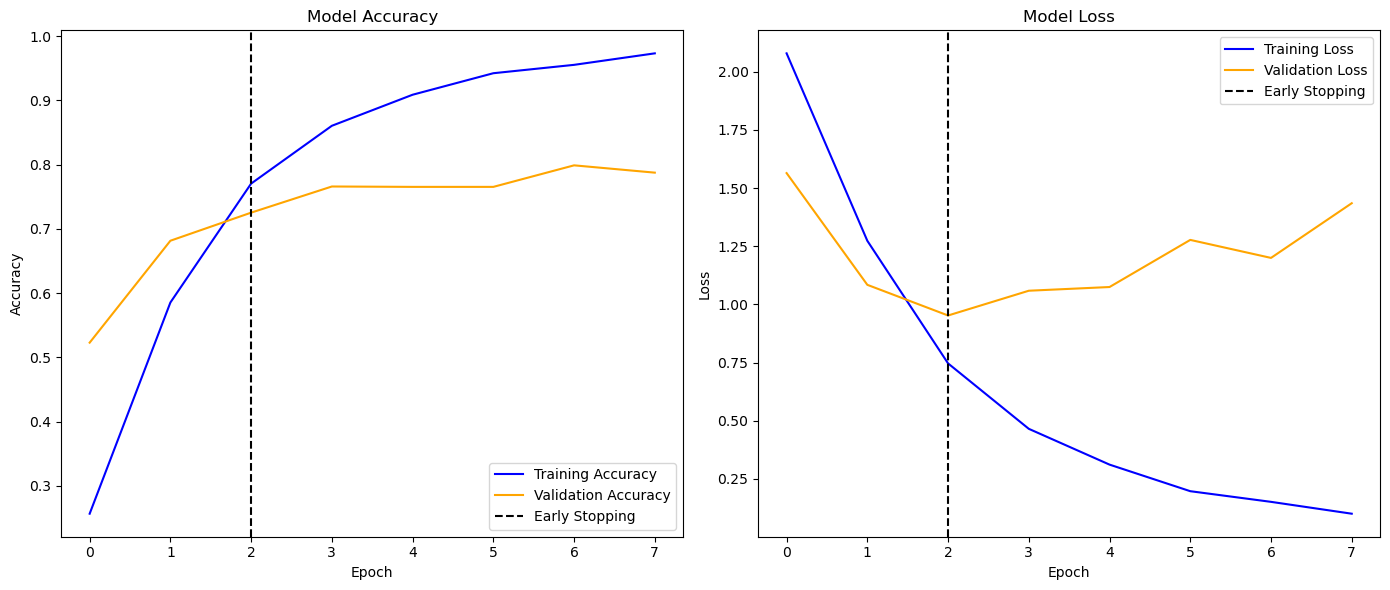

In [27]:
### COPILOT AI
# Extraer datos de la history
accuracy = h6.history['accuracy']
val_accuracy = h6.history['val_accuracy']
loss = h6.history['loss']
val_loss = h6.history['val_loss']

best_epoch = np.argmin(h6.history['val_loss'])  # Índice de la menor pérdida de validación

# Crear las gráficas
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# Gráfica de accuracy
axes[0].plot(accuracy, label='Training Accuracy', color='blue')
axes[0].plot(val_accuracy, label='Validation Accuracy', color='orange')
axes[0].axvline(best_epoch, linestyle='--', color='black', label='Early Stopping')
axes[0].set_title('Model Accuracy')
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Accuracy')
axes[0].legend()

# Gráfica de loss
axes[1].plot(loss, label='Training Loss', color='blue')
axes[1].plot(val_loss, label='Validation Loss', color='orange')
axes[1].axvline(best_epoch, linestyle='--', color='black', label='Early Stopping')
axes[1].set_title('Model Loss')
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('Loss')
axes[1].legend()

plt.tight_layout()
plt.show()

Es interesante como la mejor accuracy del modelo fue en la época 6, con una accuracy de aproximadamente 0.8. Sin embargo, la pérdida del modelo aumentaba, por lo que podemos concluir que las predicciones incorrectas que hacía lo eran por un margen cada vez mayor.

Creo que hay una disparidad significativa entre ambos criterios de precisión del modelo para train y para CV. Esto podría indicar sobre ajuste. 

In [33]:
m10 = Sequential() #modelo 2

# convolucion
m10.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=inputShape))
m10.add(layers.Conv2D(64, (3, 3), activation='relu'))
m10.add(layers.BatchNormalization())
m10.add(layers.MaxPooling2D((4, 4)))

# capas densas y dropout
m10.add(Flatten())
m10.add(Dense(128, activation='relu'))
m10.add(layers.BatchNormalization())
m10.add(Dense(64, activation='relu'))
m10.add(Dense(32, activation='relu'))
m10.add(layers.BatchNormalization())
m10.add(Dropout(0.2))
m10.add(Dense(10, activation='softmax'))

# compilacion
m10.compile(
    optimizer=Adam(learning_rate=0.0005),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

m10.summary()

c:\Users\joabl\anaconda3\envs\tf\lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_9"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_17 (Conv2D)              │ (None, 138, 138, 32)   │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_18 (Conv2D)              │ (None, 136, 136, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 136, 136, 64)   │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_8 (MaxPooling2D)  │ (None, 34, 34, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_8 (Flatten)             │ (None, 73984)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_35 (Dense)                │ (None, 128)            │     9,470,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_36 (Dense)                │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_37 (Dense)                │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 32)             │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_8 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_38 (Dense)                │ (None, 10)             │           330 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 9,500,458 (36.24 MB)

 Trainable params: 9,500,010 (36.24 MB)

 Non-trainable params: 448 (1.75 KB)

one last shot i guess. Se usaran inputs de 140x140 porque así se entrenó el m6

In [34]:
h10 = m10.fit(# history 10
    train_generator,
    epochs=30,
    batch_size=64,
    validation_data=validation_generator,
    callbacks=[early_stopping]
)

c:\Users\joabl\anaconda3\envs\tf\lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/30
123/123 ━━━━━━━━━━━━━━━━━━━━ 154s 1s/step - accuracy: 0.1692 - loss: 2.4948 - val_accuracy: 0.1635 - val_loss: 2.2828
Epoch 2/30
123/123 ━━━━━━━━━━━━━━━━━━━━ 93s 759ms/step - accuracy: 0.4919 - loss: 1.6239 - val_accuracy: 0.3000 - val_loss: 2.1235
Epoch 3/30
123/123 ━━━━━━━━━━━━━━━━━━━━ 93s 757ms/step - accuracy: 0.6812 - loss: 1.0814 - val_accuracy: 0.3754 - val_loss: 1.8802
Epoch 4/30
123/123 ━━━━━━━━━━━━━━━━━━━━ 92s 751ms/step - accuracy: 0.8202 - loss: 0.6750 - val_accuracy: 0.5479 - val_loss: 1.3937
Epoch 5/30
123/123 ━━━━━━━━━━━━━━━━━━━━ 98s 797ms/step - accuracy: 0.8733 - loss: 0.4941 - val_accuracy: 0.7257 - val_loss: 1.0199
Epoch 6/30
123/123 ━━━━━━━━━━━━━━━━━━━━ 138s 1s/step - accuracy: 0.9283 - loss: 0.3263 - val_accuracy: 0.7216 - val_loss: 0.9597
Epoch 7/30
123/123 ━━━━━━━━━━━━━━━━━━━━ 90s 731ms/step - accuracy: 0.9606 - loss: 0.2087 - val_accuracy: 0.7305 - val_loss: 0.9396
Epoch 8/30
123/123 ━━━━━━━━━━━━━━━━━━━━ 90s 732ms/step - accuracy: 0.9766 - loss: 0.151

No mejoró. Ya me quedo con el otro modelo

## Evaluación de `m6`

In [ ]:
m6.save('m6.h5')

In [9]:
from tensorflow.keras.models import load_model
m6 = load_model('m6.h5')

In [10]:
myLoss, myAcc = m6.evaluate(test_generator)

c:\Users\joabl\anaconda3\envs\tf\lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


51/51 ━━━━━━━━━━━━━━━━━━━━ 12s 230ms/step - accuracy: 0.7453 - loss: 0.8307


Ahora hay que visualizar qué tan bueno es el modelo. Antes de hacer una matriz de confusión, actualizaré el ``test_generator`` para que las etiquetas que se obtengan correspondan a las predicciones hechas por el modelo

In [15]:
test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=targetSize,
    batch_size=32,
    class_mode='categorical',
    color_mode='grayscale',
    shuffle=False
)

Found 1615 images belonging to 10 classes.


51/51 ━━━━━━━━━━━━━━━━━━━━ 11s 220ms/step


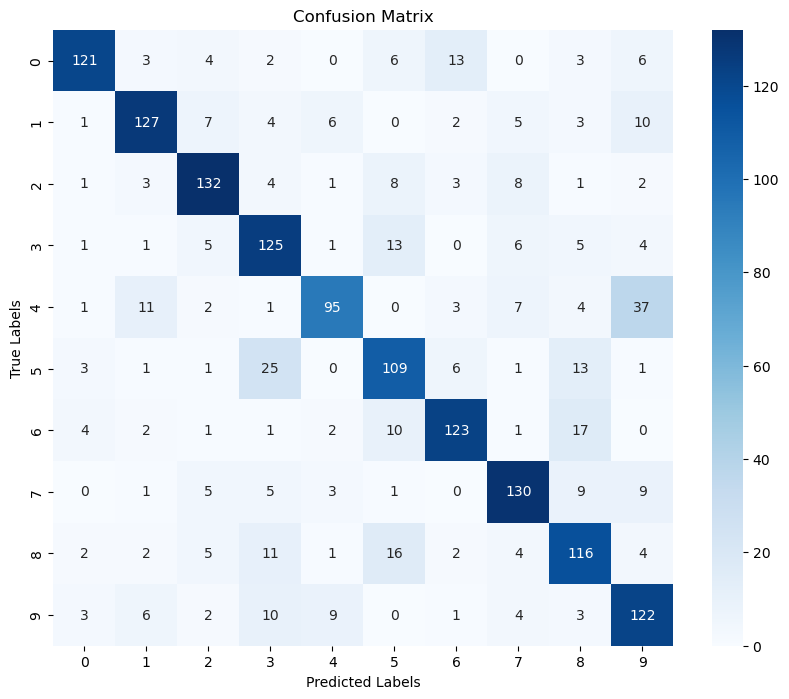

              precision    recall  f1-score   support

           0       0.88      0.77      0.82       158
           1       0.81      0.77      0.79       165
           2       0.80      0.81      0.81       163
           3       0.66      0.78      0.72       161
           4       0.81      0.59      0.68       161
           5       0.67      0.68      0.67       160
           6       0.80      0.76      0.78       161
           7       0.78      0.80      0.79       163
           8       0.67      0.71      0.69       163
           9       0.63      0.76      0.69       160

    accuracy                           0.74      1615
   macro avg       0.75      0.74      0.74      1615
weighted avg       0.75      0.74      0.74      1615



In [17]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

# Obtener las etiquetas verdaderas y las predicciones del modelo
true_labels = test_generator.classes
class_labels = list(test_generator.class_indices.keys())  # Nombres de las clases

# Predicciones del modelo
predictions = m6.predict(test_generator)
predicted_labels = predictions.argmax(axis=1)

# Generar la matriz de confusión
conf_matrix = confusion_matrix(true_labels, predicted_labels)

# Visualizar la matriz de confusión
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

# Generar el reporte de clasificación
report = classification_report(true_labels, predicted_labels, target_names=class_labels)
print(report)

Efectivamente la accuracy corresponde a la obtenida previamente. Los f1-scores y los números de la matriz de confusión nos dan indicios sobre qué números el modelo batalla para identificar correctamente. Por ejemplo, si bien se ha vuelto bueno para identificar el 0, 1, 2, 6 y 7, batalla un poco más para identificar 3, 4, 5, 8 y 9. 

En cuanto a precision vs recall, podemos ver que en el 4 se toma su tiempo para hacer una predicción positiva (mejor precision), mientras que en general es más probable que te prediga los numeros 3 y 9, y que se equivoque (mejor recall). En los demás realmente ambos están balanceados.

Y es notable el 88% de precisión para el cero. Se ha vuelto bueno identificándolo

Además, cabe mencionar la similitud entre el aproximadamente 71% de accuracy en CV con el aproximadamente 74% de accuracy. Esto nos confirma que la CV fue buena para estimar la verdadera accuracy del modelo (para las particiones que se hizo en este trabajo)

# Real time predictions

Es ahora de hacer predicciones en tiempo real

In [20]:
### con ayuda de IA
import cv2
def procesarImagen(imagen):
    imagenGris = cv2.cvtColor(imagen, cv2.COLOR_BGR2GRAY)
    imagenProcesada = cv2.resize(imagenGris, (140, 140))
    imagenProcesada = imagenProcesada / 255.0
    # Agregar una dimensión para el canal (140, 140) -> (140, 140, 1)
    imagenProcesada = np.expand_dims(imagenProcesada, axis=-1)
    # Agregar una dimensión para el batch (140, 140, 1) -> (1, 140, 140, 1)
    imagenProcesada = np.expand_dims(imagenProcesada, axis=0)
    return imagenProcesada

cap = cv2.VideoCapture(0)

while True:
    ret, frame = cap.read()
    imgProcesada = procesarImagen(frame)
    prediccion = m6.predict(imgProcesada)
    probabilidades = prediccion[0]
    labelGanador = np.argmax(prediccion)
    
    for i, prob in enumerate(probabilidades):
        color = (0, 255, 0) if i == labelGanador else (0, 0, 255)  # Verde para la clase ganadora, rojo para las demás
        texto = f"Clase {i}: {prob:.2f}"
        cv2.putText(frame, texto, (10, 30 + i * 30), cv2.FONT_HERSHEY_SIMPLEX, 0.7, color, 2)
    
    cv2.imshow('Prediccion de digitos', frame)
    # Salir si se presiona la tecla 'q'
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break

# Liberar la cámara y cerrar las ventanas
cap.release()
cv2.destroyAllWindows()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━